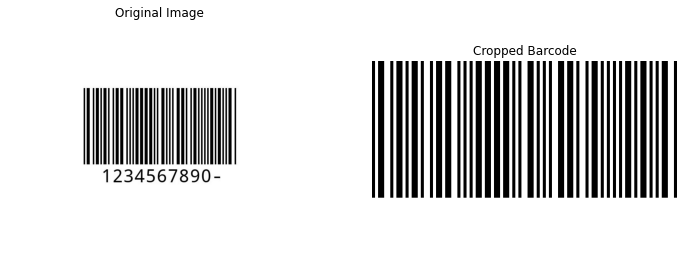

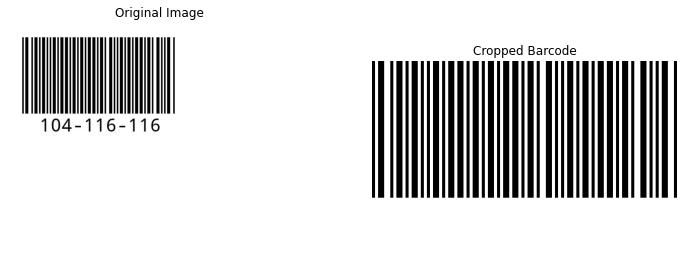

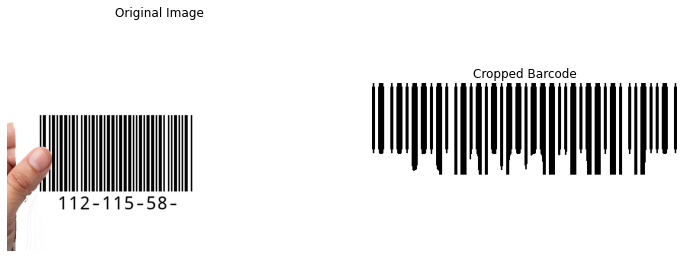

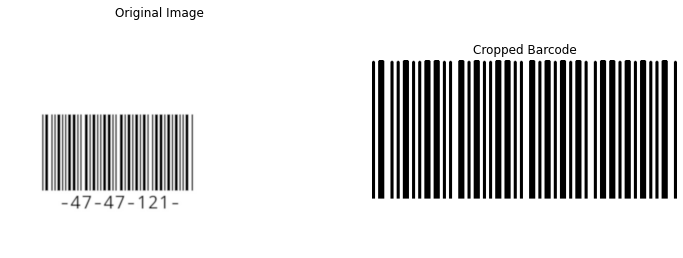

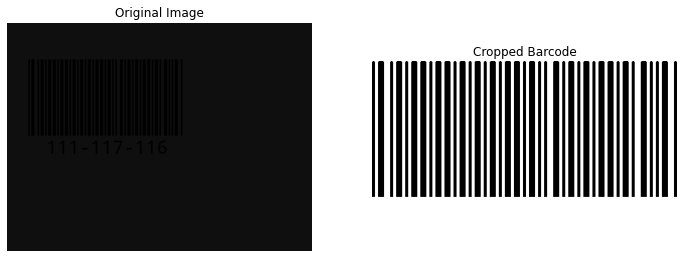

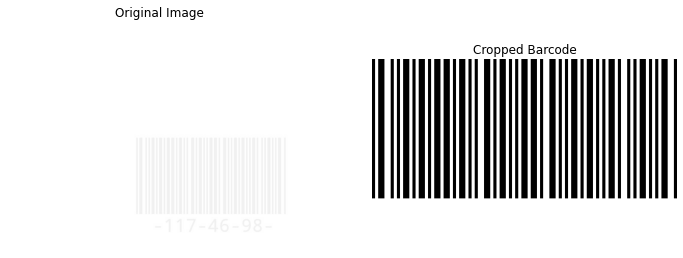

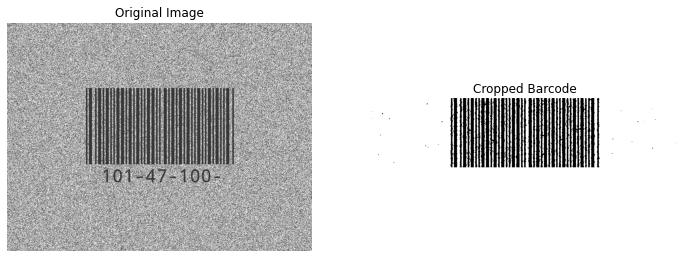

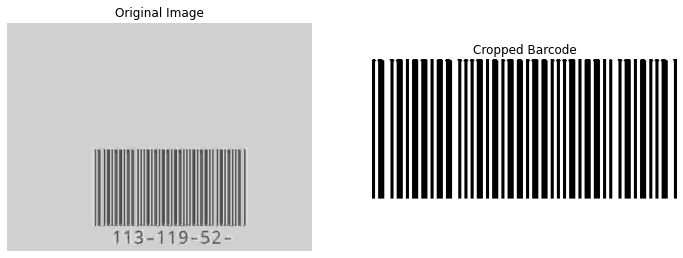

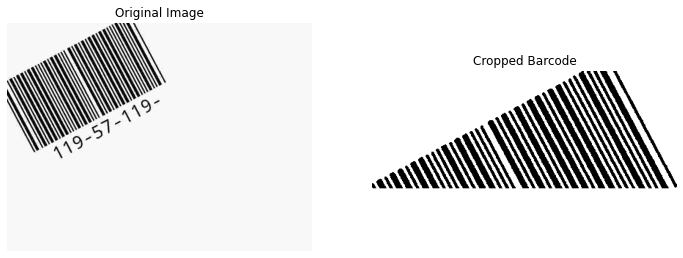

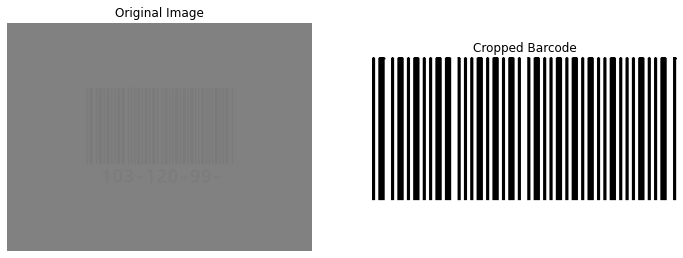

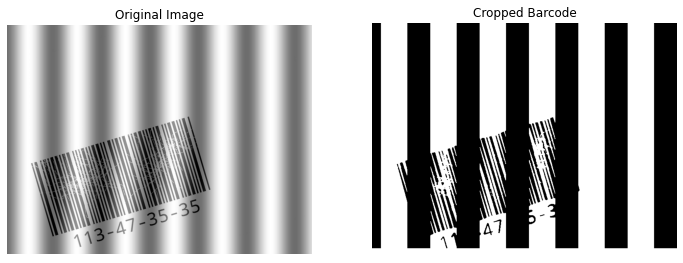

In [1]:
import os
from typing import Optional
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


def clean(img: np.ndarray, margin: int = 20) -> np.ndarray:
    """
    Crops the barcode region from the image based on contours.
    """
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    _, thresholded = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  # Return the original image if no contours are found

    x_min = min(cv.boundingRect(c)[0] for c in contours)
    x_max = max(cv.boundingRect(c)[0] + cv.boundingRect(c)[2] for c in contours)
    _, y, _, h = cv.boundingRect(max(contours, key=cv.contourArea))

    cropped_img = img[y:y + h, x_min:x_max]
    cropped_img[-margin:, :] = 255  # Set the bottom margin to white

    return cropped_img


def preprocess_image(image: np.ndarray) -> np.ndarray:
 
    img = image.copy()

    # Detect and remove hand if present
    hand_removed_img = remove_hand(img)
    if hand_removed_img is not None:
        img = hand_removed_img

    # Ensure the image is in grayscale
    if len(img.shape) == 3:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Apply further preprocessing
    img_blurred = cv.medianBlur(cv.blur(img_gray, (3, 3)), 3)
    _, img_denoised = cv.threshold(img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return img_denoised


def remove_hand(img: np.ndarray) -> Optional[np.ndarray]:
    """
    Detects and removes hand regions from the image using inpainting, and ensures the barcode is intact.
    """
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Define a comprehensive skin color range
    lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
    upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)
    lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
    upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)

    # Create two masks to cover the skin color range
    mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
    mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
    skin_mask = cv.bitwise_or(mask1, mask2)

    # Morphological operations to remove noise and close gaps
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_CLOSE, kernel, iterations=2)
    skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_OPEN, kernel, iterations=2)

    # Find contours in the skin mask
    contours, _ = cv.findContours(skin_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  # Return the original image if no hand is detected

    # Assume the largest contour is the hand
    largest_contour = max(contours, key=cv.contourArea)

    # Create a mask for the hand
    hand_mask = np.zeros_like(skin_mask)
    cv.drawContours(hand_mask, [largest_contour], -1, 255, thickness=cv.FILLED)

    # Invert the hand mask to prepare for inpainting
    hand_mask_inv = cv.bitwise_not(hand_mask)

    # Remove the hand using inpainting
    img_no_hand = cv.inpaint(img, hand_mask, inpaintRadius=3, flags=cv.INPAINT_TELEA)

    # Repair barcode area
    gray = cv.cvtColor(img_no_hand, cv.COLOR_BGR2GRAY)

    # Step 1: Erosion to remove small artifacts
    erosion_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 50))  # Smaller height for precise artifact removal
    binary_erode = cv.erode(gray, erosion_kernel, iterations=2)  # Increased iterations for stronger effect

    # Step 2: Dilation to restore barcode lines
    dilation_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 60))  # Matching or slightly larger kernel
    binary_opened = cv.dilate(binary_erode, dilation_kernel, iterations=3)  # Increased iterations for better line restoration

    # Step 3: Fine adjustment using another dilation
    dilationkernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 10))  # Smaller kernel for final touch
    binary_final = cv.dilate(binary_opened, dilationkernel2, iterations=2)

    # Step 4: Smoothing with a vertical filter
    kernel = np.ones((30, 1), np.float32) / 30  # Reduced kernel size for finer filtering
    vertical_mean_filtered = cv.filter2D(binary_final, -1, kernel)

    # Step 5: Normalize to ensure pixel intensities are correct
    img = cv.normalize(vertical_mean_filtered, None, 0, 255, cv.NORM_MINMAX)

    # Step 6: Final dilation for consistency and line enhancement
    img = cv.dilate(img, cv.getStructuringElement(cv.MORPH_RECT, (1, 8)), iterations=2)

    return img



def display_before_after(
    original_img: np.ndarray, cropped_img: np.ndarray, title_before: str = "Original Image",
    title_after: str = "Cropped Barcode"
):
    """
    Displays the original and processed images side by side.
    """
    plt.figure(figsize=(12, 6))
    images = [(original_img, title_before), (cropped_img, title_after)]
    for i, (img, title) in enumerate(images):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img if len(img.shape) == 2 else cv.cvtColor(img, cv.COLOR_BGR2RGB),
                   cmap='gray' if len(img.shape) == 2 else None)
        plt.title(title)
        plt.axis("off")
    plt.show()


def process_test_cases(image_folder: str, special_image_index: Optional[int] = None):
    """
    Processes test cases by cleaning and cropping barcodes from images in the folder.
    """
    files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    files.sort(key=lambda x: int(os.path.splitext(x)[0].split()[0]))
    output_folder = os.path.join(image_folder, "Processed_Output")
    os.makedirs(output_folder, exist_ok=True)

    for i, file_name in enumerate(files):
        image_path = os.path.join(image_folder, file_name)
        original_img = cv.imread(image_path)
        if original_img is None:
            print(f"Could not read image {file_name}. Skipping...")
            continue

        cleaned_img = preprocess_image(original_img)
        cropped_img = clean(cleaned_img)
        cv.imwrite(os.path.join(output_folder, f"Cropped_{file_name}"), cropped_img)
        display_before_after(original_img, cropped_img)


if __name__ == "__main__":
    folder = "/Users/mohamedwalid/Desktop/Semester 7/Computer vision/CV-main/Test Cases-20241123"
    process_test_cases(folder, special_image_index=7)


In [2]:

def decoder(your_cropped_image):
    """
    Decodes a Code 11 barcode from a cropped image.
    
    Args:
        your_cropped_image (numpy.ndarray): The cropped barcode image in grayscale.
        
    Returns:
        list: Decoded digits as a list of strings, excluding 'Stop/Start'.
    """
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = your_cropped_image.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    return digits

cropped_image_path_Folder = '/Users/mohamedwalid/Desktop/Semester 7/Computer vision/CV-main/Test Cases-20241123/Processed_Output'

# Get a sorted list of image files
cropped_images = sorted(os.listdir(cropped_image_path_Folder))

for cropped_image in cropped_images:
    cropped_image_path = os.path.join(cropped_image_path_Folder, cropped_image)
    cropped_img = cv.imread(cropped_image_path, cv.IMREAD_GRAYSCALE)
    if cropped_img is not None:
        decoded_digits = decoder(cropped_img)
        print("Decoded barcode:", ''.join(decoded_digits))

Decoded barcode: Stop/Start1234567890-Stop/Start
Decoded barcode: Stop/Start104-116-116Stop/Start
Decoded barcode: Stop/Start112-115-58-Stop/Start
Decoded barcode: Stop/Start-47-47-121-Stop/Start
Decoded barcode: Stop/Start111-117-116Stop/Start
Decoded barcode: Stop/Start-117-46-98-Stop/Start
Decoded barcode: 
Decoded barcode: Stop/Start113-119-52-Stop/Start
Decoded barcode: 
Decoded barcode: Stop/Start103-120-99-Stop/Start
Decoded barcode: 
